## Radial Basis Function Networks

Used for Regression or Function approximation. RBF nets can learn to approximate trends using many Gaussian/bell curves

RBF net is similar to a 2-layer network:

**Hidden Layer**: Gaussian RBF used as an "activation" function
**Output Layer**: Performs weighted sum

### Gaussian/Normal Distribution (Bell Curve)

$N(x; \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}$, where $\mu$ is **mean** and $\sigma$ is **standard deviation**

Above function is known as the **probability density function (pdf)**, but we're only concerned with the bell-curve properties of Gaussians, not the probability distribution.

#### Gaussian Centers

Need **K-means Clustering** to place the Gaussian centers. That way the Gaussian will span the clusters of data. Multiple Gaussians summed up can approximate any function.

#### Standard Deviations

Two Options to set standard deviations:

1. Set as standard deviation of points assigned to a particular cluster
2. Set a single standard deviation as $\sigma_j = \sigma \forall j$, where $\sigma = \frac{d_{max}}{\sqrt{2k}}$ and $d_{max}$ is the maximum distance between any two cluster centers and $k$ is the number of clusters

### Backpropagation

RBF Network produces a weighted sum output given an input x:

$F(x) = \sum_{j=1}^k w_j\phi_j(x, c_j) + b$, where $w_j$ is the weight, $b$ is the bias, $k$ is the number of clusters, and $\phi()$ is the Gaussian RBF:

$\phi_j(x, c_j) = exp(\frac{-||x-c_j||^2}{2\sigma^2_j})$

#### Quadratic Cost Function

$C = \sum_{i=1}^N (y^{(i)} - F(x^{(i)}))^2$

Compute partial derivative of the cost function with respect to $w_j$

$\frac{\partial C}{\partial w_j} = \frac{\partial C}{\partial F} \frac{\partial F}{\partial w_j}
= \frac{\partial}{\partial F} [\sum_{i=1}^N (y^{(i)} - F(x^{(i)}))^2] * \frac{\partial}{\partial w_j} [\sum_{j=0}^K w_j \phi_j (x, c_j) + b] = -(y^{(i)} - F(x^{(i)})) * \phi_j(x, c_j)$

$w_j \leftarrow w_j + \eta(y^{(i)} - F(x^{(i)})) \phi_j(x, c_j)$


Similarly compute partial derivative of cost function with respect to $b$

$\frac{\partial C}{\partial b} = \frac{\partial C}{\partial F} \frac{\partial F}{\partial b}$

$= \frac{\partial}{\partial F} [\sum_{i=1}^N (y^{(i)} - F(x^{(i)}))^2] * \frac{\partial}{\partial b} [\sum_{j=0}^K w_j \phi_j (x, c_j) + b] = -(y^{(i)} - F(x^{(i)})) * 1$

$b \leftarrow b + \eta(y^{(i)} - F(x^{(i)}))$

In [8]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Gaussian RBF
def rbf(x, c, s):
    return np.exp(-1 / (2 * s**2) * (x-c)**2)

In [19]:
# K-means clustering to determine the cluster centers
# X {ndarray} -- A Mx1 array of inputs
# k {int} -- Number of clusters
# Returns -- kx1 array of final cluster centers
def kmeans(X, k):
    # randomly select initial clusters from input data
    clusters = np.random.choice(np.squeeze(X), size=k)
    prevClusters = clusters.copy()
    stds = np.zeros(k)
    converged = False
    
    while not converged:
        # Compute distances from each cluster center to each point
        distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
        
        # Find closest cluster to each point
        closestCluster = np.argmin(distances, axis=1)
        
        # Update clusters by taking the mean of all the points assigned to that cluster
        for i in range(k):
            pointsForCluster = X[closestCluster == i]
            if len(pointsForCluster) > 0:
                clusters[i] = np.mean(pointsForCluster, axis=0)
                
        # Converge if clusters haven't moved 
        converged = np.linalg.norm(clusters - prevClusters) < 1e-6
        prevClusters = clusters.copy()
    
    distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
    closestCluster = np.argmin(distances, axis=1)
    
    clustersWithNoPoints = []
    for i in range(k):
        pointsForCluster = X[closestCluster == i]
        if len(pointsForCluster) < 2:
            # Track cluster with 0 or 1 points
            clustersWithNoPoints.append(i)
            continue
        else:
            stds[i] = np.std(X[closestCluster == i])
    
    # Use mean std of clusters for clusters with no points
    if len(clustersWithNoPoints) > 0:
        pointsToAverage = []
        for i in range(k):
            if i not in clustersWithNoPoints:
                pointsToAverage.append(X[closestCluster == i])
        pointsToAverage = np.concatenate(pointsToAverage).ravel()
        stds[clustersWithNoPoints] = np.mean(np.std(pointsToAverage))
    
    return clusters, stds

In [27]:
# Radial Basis Function Network
class RBFNet(object):
    def __init__(self, k=2, lr=0.01, epochs=100, rbf=rbf, inferStds=True):
        self.k = k
        self.lr = lr
        self.epochs = epochs
        self.rbf = rbf
        self.inferStds = inferStds
        
        self.w = np.random.randn(k)
        self.b = np.random.randn(1)
        
    # Fit function to compute weights and biases
    def fit(self, X, y):
        if self.inferStds:
            # Compute stds from data
            self.centers, self.stds = kmeans(X, self.k)
        else:
            # use a fixed std
            self.centers, _ = kmeans(X, self.k)
            dMax = max([np.abs(c1 - c2) for c1 in self.centers for c2 in self.centers])
            self.stds = np.repeat(dMax / np.sqrt(2*self.k), self.k)

        # Training
        for epoch in range(self.epochs):
            for i in range(X.shape[0]):
                # Forward pass
                a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
                F = a.T.dot(self.w) + self.b

                # backward pass
                error = -(y[i] - F).flatten()

                # online update
                self.w = self.w - self.lr * a * error
                self.b = self.b - self.lr * error
        
    def predict(self, X):
        y_pred = []
        for i in range(X.shape[0]):
            a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
            F = a.T.dot(self.w) + self.b
            y_pred.append(F)
        return np.array(y_pred)

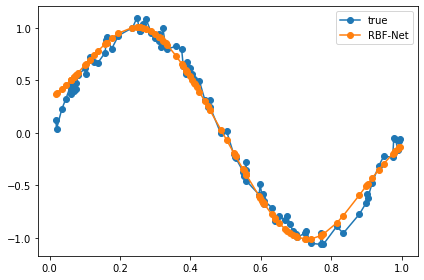

In [32]:
# Create data: sample inputs from sine function + uniform noise
NUM_SAMPLES = 100
X = np.random.uniform(0., 1., NUM_SAMPLES)
X = np.sort(X, axis=0)
noise = np.random.uniform(-0.1, 0.1, NUM_SAMPLES)
y = np.sin(2 * np.pi * X) + noise

rbfnet = RBFNet(lr=1e-2, k=2)
rbfnet.fit(X, y)

y_pred = rbfnet.predict(X)
plt.plot(X, y, '-o', label='true')
plt.plot(X, y_pred, '-o', label='RBF-Net')
plt.legend()

plt.tight_layout()
plt.show()